In [2]:
import pandas as pd
import csv
import re
import warnings
import time 
warnings.filterwarnings('ignore')
begin_start = time.time()

In [3]:
file = "big_df.csv"  #large file for production
#file = "small_R_df.csv"       #small file for development
df = pd.read_csv('private/'+file, delimiter='|', encoding='latin-1')

In [4]:
#### stripping HTML tags ####
p = '<.*?>'
for col in df.columns:
    df[col] = df[col].replace(p, '', regex=True)

In [5]:
# splitting categories into main and sub, dropping non-Book main categories #
regex = r"\/(.*?)\/.*"

df['sub_cat'] = df['categoryPath'].str.extract(regex) # sub categories, one level below Books.
df['main_cat'] = df['categoryPath'].astype(str).str[:5] 
df = df[df.main_cat == 'Books'] #dropping non-Book categories

# drop rows missing critical data #
df = df.dropna(axis=0, how='any', subset=['longDn', 'sub_cat','name'])
df.isnull().sum().sort_values(ascending=False)

model           241307
parentItemId      3826
itemId            3375
shortDn            202
main_cat             0
sub_cat              0
catNode              0
longDn               0
categoryPath         0
name                 0
dtype: int64

In [6]:
print("There are " + str(len(df.sub_cat.value_counts())) + " categories of books.")
counts = df['sub_cat'].value_counts()
threshold = 100
print(str(len(counts[counts>threshold])) + " categories have more than " + str(threshold) +" books.")

There are 74 categories of books.
56 categories have more than 100 books.


In [7]:
Top_40_cats = df.sub_cat.value_counts().iloc[:39].index.tolist()

#df.sub_cat.value_counts().iloc[30:40]
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20751
Children's & Kids' Books                    19802
Medical Books                               19238
History Books                               16723
Education Books                             14108
Computers & Technology Books                12785
Biographies & Memoirs                       10257
Sports & Outdoor Books                      10054
Law Books                                    9635
Political Books                              9273
Self-Help Books                              7097
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6473
Mathematics Books                            6387
Philosophy Books                             6110
Travel Books                                 5810
Language Arts & Disciplines Books            5767
Reference Books                              5670
Foreign Language Study & Reference Books     5547
Teen & Young Adult Books                     5358


In [8]:
# Only keep records for top n populated categories (drop sparsely populated categories)
df = df.loc[df['sub_cat'].isin(Top_40_cats)]

In [9]:
df.sub_cat.value_counts().tail(n=30)

Political Books                             9273
Self-Help Books                             7097
Health & Wellness Books                     6852
Crafts & Hobbies Books                      6473
Mathematics Books                           6387
Philosophy Books                            6110
Travel Books                                5810
Language Arts & Disciplines Books           5767
Reference Books                             5670
Foreign Language Study & Reference Books    5547
Teen & Young Adult Books                    5358
Cookbooks, Food & Wine                      5031
Study Aids & Test Prep Books                3846
Humor Books                                 3491
Comic Books & Graphic Novels                3206
Literature & Fiction Books                  3163
Arts & Entertainment Books                  2570
Religion & Spirituality Books               2515
Psychology & Social Science Books           2336
Science & Nature Books                      1930
Libros en Espanol   

In [10]:
df.sub_cat.value_counts().iloc[:39].index.tolist()

#df.sub_cat.value_counts().iloc[30:40]
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20751
Children's & Kids' Books                    19802
Medical Books                               19238
History Books                               16723
Education Books                             14108
Computers & Technology Books                12785
Biographies & Memoirs                       10257
Sports & Outdoor Books                      10054
Law Books                                    9635
Political Books                              9273
Self-Help Books                              7097
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6473
Mathematics Books                            6387
Philosophy Books                             6110
Travel Books                                 5810
Language Arts & Disciplines Books            5767
Reference Books                              5670
Foreign Language Study & Reference Books     5547
Teen & Young Adult Books                     5358


In [11]:
#R_data_for_LDA = df
#R_data_for_LDA.to_csv('private/py_export_'+file, sep='|')

# Preparing Corpus and BOW for LDA Topic Modeling with Gensim
#### references used:
> http://mallet.cs.umass.edu/  
> https://radimrehurek.com/gensim/models/ldamodel.html  
> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
> https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [12]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk; nltk.download('stopwords')
#!python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [14]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['book'])

In [15]:
print(df.sub_cat.unique())

['Arts & Entertainment Books' "Children's & Kids' Books"
 'Business & Money Books' 'Cookbooks, Food & Wine'
 'Crafts & Hobbies Books' 'Literature & Fiction Books'
 'Religion & Spirituality Books' 'Dieting & Fitness Books'
 'Study Aids & Test Prep Books' 'Health & Wellness Books'
 'Biographies & Memoirs' 'Reference Books' 'Humor Books'
 'Libros en Espanol' 'Computers & Technology Books'
 'Comic Books & Graphic Novels' 'Teen & Young Adult Books' 'Medical Books'
 'Self-Help Books' 'History Books' 'True Crime Books'
 'Psychology & Social Science Books' 'House, Home & Gardening Books'
 'Travel Books' 'Education Books' 'Engineering & Transportation Books'
 'Science & Nature Books' 'Language Arts & Disciplines Books' 'Law Books'
 'Foreign Language Study & Reference Books' 'Mathematics Books'
 'Political Books' 'Philosophy Books' 'Sports & Outdoor Books'
 'Language Arts & Disciplines' 'Business & Money' 'Nonfiction' 'History'
 'Law']


In [16]:
data = df.longDn.values.tolist()

In [17]:
# converting contractions
data = [re.sub("won't","will not", sent) for sent in data]
data = [re.sub("can't","can not", sent) for sent in data]
data = [re.sub("n't","not", sent) for sent in data]
data = [re.sub("\'ll"," will", sent) for sent in data]
data = [re.sub("\'re"," are", sent) for sent in data]
data = [re.sub("\'ve"," have", sent) for sent in data]

# removing any single quotes
data = [re.sub("\'", " ", sent) for sent in data] 
# removing pipes to help with saving csv as pipe-delimited
data = [re.sub("\|", " ", sent) for sent in data]
# leave only letters and numbers (makes above lines redundant, but that's ok)
data = [re.sub("[^a-zA-Z0-9 ]", " ", sent) for sent in data]
# removing any extraneous spaces
data = [re.sub("\s+", " ", sent) for sent in data] #strip extra spaces

<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence 

In [18]:
data[300]

'Robust DC Comics Roster Engage in epic match ups with a massive roster of DC Comics heroes and villains including Batman Cyborg The Flash Harley Quinn Nightwing Solomon Grundy Superman and Wonder Woman Master God Like Powers Unleash each character s unique super powers with individual move sets and environmental interactions Uncontainable Battles Fight through multi tiered fighting arenas by hurling opponents through buildings and launching them off cliffs Original DC Comics Saga Set in Iconic Environments Experience an authentic DC Comics storyline created in collaboration between NetherRealm Studios DC Entertainment and writers Justin Gray and Jimmy Palmiotti Players will discover and do battle in numerous iconic locales pulled from DC Comics lore Destructive Fighter in which the World is a Weapon Experience epic battles on a massive scale as players control the most powerful beings in the universe in destructible interactive environments Destroy elements of the world and use super 

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[4]]])

In [21]:
start = time.time()
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

end = time.time()
print(end-start)

0.00049591064453125


In [22]:
start = time.time()
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:4])
end = time.time()
print(end-start)

C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])


3058.4223012924194


In [23]:
start = time.time()

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
end = time.time()
print(end-start)

135.01927089691162


# Begin LDA Model

## best model: LdaModel, 40 topic, 100 random state, 5k chunksize, 2 passes, per_word True

In [26]:

start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)
end = time.time()
print(end-start)


1112.2461738586426


In [27]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(34,
  '0.031*"et" + 0.019*"la" + 0.013*"dan" + 0.008*"par" + 0.007*"qui" + '
  '0.007*"ad" + 0.006*"ce" + 0.005*"circuit" + 0.004*"son" + '
  '0.004*"histoire_french"'),
 (35,
  '0.038*"state" + 0.026*"imperfection" + 0.019*"may" + 0.018*"edition" + '
  '0.017*"excerpt" + 0.017*"book" + 0.017*"find" + 0.017*"com" + '
  '0.017*"thousand" + 0.016*"remain"'),
 (36,
  '0.016*"travel" + 0.016*"adventure" + 0.012*"water" + 0.011*"mountain" + '
  '0.011*"trail" + 0.010*"sea" + 0.010*"island" + 0.010*"mile" + 0.010*"river" '
  '+ 0.010*"boat"'),
 (24,
  '0.063*"war" + 0.026*"military" + 0.019*"army" + 0.014*"battle" + '
  '0.012*"soldier" + 0.011*"fight" + 0.009*"combat" + 0.008*"event" + '
  '0.008*"force" + 0.008*"operation"'),
 (3,
  '0.080*"work" + 0.040*"part" + 0.021*"miss" + 0.020*"believe" + '
  '0.018*"reproduction" + 0.017*"imperfection" + 0.017*"may" + '
  '0.015*"culturally_important" + 0.015*"soccer" + 0.015*"appreciate"'),
 (17,
  '0.029*"japanese" + 0.021*"algorithm" + 0.020*"

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.156643867213239

Coherence Score:  0.5382685725952262


In [29]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
print(end - begin_start)
vis

C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


599.1846203804016
6691.594702720642


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
14     11.876647        1       1 -0.269895 -0.068170
32     11.303590        1       2 -0.294750 -0.093549
9      11.115760        1       3 -0.278199  0.206139
27     10.239989        1       4 -0.271445 -0.162549
5       9.556064        1       5 -0.300760  0.091447
21      4.814595        1       6 -0.213092 -0.042330
1       3.399028        1       7 -0.201779  0.138312
15      2.768367        1       8 -0.130896  0.156502
38      2.345121        1       9 -0.127161  0.149684
29      2.120984        1      10 -0.080587 -0.249558
36      2.021040        1      11 -0.076435 -0.127422
11      1.865953        1      12  0.121849  0.011042
10      1.836307        1      13  0.132603  0.027482
7       1.735952        1      14  0.004379 -0.016545
37      1.546508        1      15  0.041081  0.053008
18      1.540995        1      16 -0.032540  0.059958
35      1.423136        1      17  0.043582 -0.014708
23      1.366796        1      18 -0.044787 -0.060156
19      1.230496        1      19 -0.075053  0.070255
24      1.140086        1      20  0.022256 -0.182128
25      1.114567        1      21 -0.025393 -0.020103
0       1.084477        1      22  0.026178 -0.130194
26      1.082985        1      23 -0.035239  0.059576
6       1.046454        1      24  0.001850 -0.029944
12      0.908769        1      25  0.066550 -0.020470
34      0.794982        1      26  0.135626  0.043005
3       0.782495        1      27  0.080568  0.043882
39      0.754965        1      28  0.085047 -0.042348
20      0.694321        1      29  0.125021 -0.016904
33      0.680637        1      30  0.103708 -0.060247
2       0.643280        1      31  0.115464  0.017254
28      0.640055        1      32  0.147111  0.035470
13      0.636573        1      33  0.147276 -0.006024
31      0.621630        1      34  0.145286  0.026009
8       0.596613        1      35  0.098456  0.008137
22      0.560291        1      36  0.159383  0.033606
4       0.558386        1      37  0.154412  0.047448
16      0.552345        1      38  0.160629  0.026528
30      0.502157        1      39  0.167638  0.008291
17      0.496603        1      40  0.172057  0.030311, topic_info=      Category          Freq                    Term         Total  loglift  \
term                                                                          
586    Default  51291.000000                    work  51291.000000  30.0000   
155    Default  66820.000000                    life  66820.000000  29.0000   
376    Default  24098.000000                 student  24098.000000  28.0000   
1030   Default  15735.000000                   woman  15735.000000  27.0000   
713    Default  37702.000000                   learn  37702.000000  26.0000   
861    Default  30273.000000                business  30273.000000  25.0000   
84     Default  18984.000000                language  18984.000000  24.0000   
76     Default  38139.000000                   guide  38139.000000  23.0000   
936    Default  18634.000000                american  18634.000000  22.0000   
10016  Default  12566.000000                     und  12566.000000  21.0000   
2574   Default  15257.000000                   state  15257.000000  20.0000   
351    Default  22224.000000                     man  22224.000000  19.0000   
1539   Default  13209.000000                     die  13209.000000  18.0000   
791    Default  14348.000000                   datum  14348.000000  17.0000   
128    Default  48382.000000                     use  48382.000000  16.0000   
675    Default  30850.000000                   write  30850.000000  15.0000   
1821   Default  19760.000000                  system  19760.000000  14.0000   
1321   Default  11080.000000                     war  11080.000000  13.0000   
1231   Default  14904.000000                    part  14904.000000  12.0000   
1013   Default  10583.000000  

# Try to improve model: consider 36 topics, chunksize of 15,000 docs, and 10 passes. 

In [ ]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=36, 
                                           random_state=100,
                                           chunksize=15000,    # chunksize = number of docs to be used in each training chunk
                                           passes=10,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

In [ ]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
print(end - begin_start)
vis

# Begin LDA Multicore Model  
## initial results: lower coherence score but processes twice as fast

In [25]:
start = time.time()

lda_multicore_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           workers=3,
                                           num_topics=40, 
                                           random_state=100,
                                           eval_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,  # chunksize = number of docs to be used in each training chunk
                                           passes=2,        # passes = total number of training passes
                                           #alpha='auto',
                                           per_word_topics=True)
end = time.time()
print(end-start)

SyntaxError: keyword can't be an expression (<ipython-input-25-de1001505dc0>, line 3)

In [ ]:
pprint(lda_multicore_model.print_topics())
doc_lda = lda_multicore_model[corpus]

In [ ]:
start = time.time()
# Compute Perplexity
print('\nPerplexity: ', lda_multicore_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multicore_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

In [ ]:
pprint(lda_multicore_model.print_topics())
doc_lda = lda_multicore_model[corpus]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_model, corpus, id2word)
vis

# LDA Multicore model approach #2, fewer categories  
## Initial Result: No improvement.

In [69]:
start = time.time()
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           eval_every=1,      # update_every = how often the model should be updated 
                                           chunksize=10000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           per_word_topics=True)
end = time.time()
print(end-start)

204.76681232452393


In [70]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.883864614819519

Coherence Score:  0.4452825313034552


In [71]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)

end = time.time()
print(end-start)
vis

464.9169855117798


PreparedData(topic_coordinates=            Freq  cluster  topics             x         y
topic                                                    
17     10.737969        1       1  4.515359e-02  0.114358
19      7.393533        1       2  7.797553e-02 -0.009678
27      6.878052        1       3  8.348925e-02 -0.143252
6       6.726040        1       4  3.857380e-02 -0.077748
20      6.593369        1       5  2.248494e-02  0.009995
15      5.761143        1       6  3.041182e-03  0.106870
26      5.552044        1       7  5.396670e-02  0.010645
2       3.947515        1       8 -1.268712e-03  0.083428
11      3.799010        1       9  4.325874e-02 -0.073758
0       3.728054        1      10  5.849806e-02 -0.062652
13      3.694675        1      11 -1.424620e-02  0.063881
10      3.587152        1      12 -1.251912e-02  0.023548
3       3.474605        1      13 -1.919819e-03  0.015057
7       3.213003        1      14  2.490068e-02  0.009787
21      2.300317        1      15  3.401319e-02 -0.004379
23      2.261541        1      16  1.897362e-02 -0.061963
1       2.175282        1      17 -2.803580e-01 -0.069189
18      2.148599        1      18 -2.882410e-02  0.081263
12      2.146558        1      19 -1.630919e-03  0.057764
25      1.762174        1      20  9.275460e-07  0.015535
22      1.703883        1      21 -1.899562e-02  0.054945
8       1.703254        1      22 -1.853327e-02  0.046761
5       1.607288        1      23  2.334612e-03  0.010338
24      1.526057        1      24  3.208608e-02 -0.046107
29      1.306816        1      25  3.564342e-03 -0.073200
28      1.181223        1      26  8.469767e-03  0.011115
9       0.908052        1      27 -1.128777e-02  0.007082
4       0.784566        1      28 -8.339655e-03 -0.031430
16      0.752232        1      29 -8.258938e-02 -0.019587
14      0.645994        1      30 -7.027248e-02 -0.049429, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
1536  Default  13916.000000           die  13916.000000  30.0000  30.0000
9657  Default  10981.000000           der  10981.000000  29.0000  29.0000
9661  Default  10855.000000           und  10855.000000  28.0000  28.0000
24    Default  68776.000000           new  68776.000000  27.0000  27.0000
130   Default  49336.000000           use  49336.000000  26.0000  26.0000
78    Default  36607.000000         guide  36607.000000  25.0000  25.0000
352   Default  55034.000000          make  55034.000000  24.0000  24.0000
590   Default  49175.000000          work  49175.000000  23.0000  23.0000
600   Default  28384.000000         child  28384.000000  22.0000  22.0000
158   Default  58369.000000          life  58369.000000  21.0000  21.0000
1486  Default  13175.000000        recipe  13175.000000  20.0000  20.0000
84    Default  52132.000000       include  52132.000000  19.0000  19.0000
378   Default  28602.000000       student  28602.000000  18.0000  18.0000
2398  Default   8126.000000            la   8126.000000  17.0000  17.0000
780   Default  38810.000000         story  38810.000000  16.0000  16.0000
86    Default  17328.000000      language  17328.000000  15.0000  15.0000
1031  Default  14296.000000         woman  14296.000000  14.0000  14.0000
718   Default  39556.000000         learn  39556.000000  13.0000  13.0000
703   Default  13736.000000          food  13736.000000  12.0000  12.0000
863   Default  27236.000000      business  27236.000000  11.0000  11.0000
135   Default  46160.000000         world  46160.000000  10.0000  10.0000
1312  Default  21323.000000          step  21323.000000   9.0000   9.0000
8587  Default   5347.000000  imperfection   5347.000000   8.0000   8.0000
148   Default  32364.000000          find  32364.000000   7.0000   7.0000
851   Default  16276.000000          test  16276.000000   6.0000   6.0000
71    Default  33360.000000         first  33360.000000   5.0000   5.0000
797   Default  20224.000000  

# How many topics should we train? 

In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA multiecore models
    coherence_values : Coherence values corresponding to the LDA multicore model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



1555.796332359314


'\n# Show graph\nlimit=45; start=30; step=3;\nx = range(start, limit, step)\nplt.plot(x, coherence_values)\nplt.xlabel("Num Topics")\nplt.ylabel("Coherence score")\nplt.legend(("coherence_values"), loc=\'best\')\nplt.show()\n\n# Print the coherence scores\nfor m, cv in zip(x, coherence_values):\n    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))\n\nend = time.time()\nprint(end-start)\n'

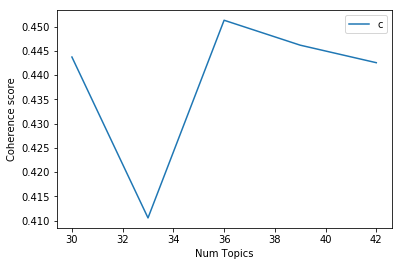

Num Topics = 30  has Coherence Value of 0.4437
Num Topics = 33  has Coherence Value of 0.4106
Num Topics = 36  has Coherence Value of 0.4513
Num Topics = 39  has Coherence Value of 0.4462
Num Topics = 42  has Coherence Value of 0.4425
1530839726.5480387


In [73]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

end = time.time()
print(end-start_time)

In [75]:
############################################################
# comparing LDA model coherence scores vs. LDA Multicore
############################################################
#          LDA Multicore results: 
#  Num Topics = 30  has Coherence Value of 0.4437
#  Num Topics = 33  has Coherence Value of 0.4106
#  Num Topics = 36  has Coherence Value of 0.4513
#  Num Topics = 39  has Coherence Value of 0.4462
#  Num Topics = 42  has Coherence Value of 0.4425
############################################################
#            LDA Model results: 
# Num Topics = 30  has Coherence Value of 0.5116
# Num Topics = 33  has Coherence Value of 0.5101
# Num Topics = 36  has Coherence Value of 0.5146
# Num Topics = 39  has Coherence Value of 0.4696
# Num Topics = 42  has Coherence Value of 0.4832
############################################################
#  As expected (and unexplained) LDA Model performs better
#  than the LDA multicore model with identical parameters 
############################################################


def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



3534.528767824173


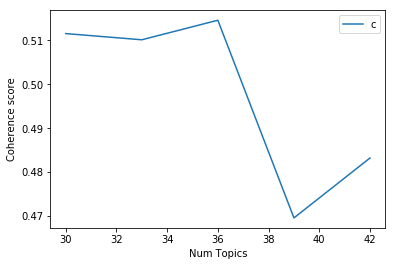

Num Topics = 30  has Coherence Value of 0.5116
Num Topics = 33  has Coherence Value of 0.5101
Num Topics = 36  has Coherence Value of 0.5146
Num Topics = 39  has Coherence Value of 0.4696
Num Topics = 42  has Coherence Value of 0.4832
3535.1085076332092


In [76]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

end = time.time()
print(end-start_time)

#          LDA Multicore results:   
>  Num Topics = 30  has Coherence Value of 0.4437  
>  Num Topics = 33  has Coherence Value of 0.4106  
>  Num Topics = 36  has Coherence Value of 0.4513  
>  Num Topics = 39  has Coherence Value of 0.4462  
>  Num Topics = 42  has Coherence Value of 0.4425   

#            LDA Model results:   
> Num Topics = 30  has Coherence Value of 0.5116  
> Num Topics = 33  has Coherence Value of 0.5101  
> Num Topics = 36  has Coherence Value of 0.5146  
> Num Topics = 39  has Coherence Value of 0.4696  
>  Num Topics = 42  has Coherence Value of 0.4832  
    
      
  As expected (and unexplained) LDA Model performs better  
  than the LDA multicore model with identical parameters   



In [ ]:
- intentional fail to prevent subsequent code to run -
fail.

# Begin LDA Mallet
### troubleshooting:
> https://searchcode.com/codesearch/view/92751630/ - code  
> https://github.com/RaRe-Technologies/gensim/issues/818 - bug identified?   

In [31]:
from gensim.models.wrappers import LdaMallet

In [45]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'mallet-2.0.8/bin/mallet' 

In [69]:
ldamallet = gensim.models.wrappers.ldamallet.LdaMallet('mallet_2.0.8/bin/mallet', corpus=corpus, num_topics=40, id2word=id2word, workers=3)

CalledProcessError: Command 'mallet_2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\BS\AppData\Local\Temp\9e78c3_corpus.txt --output C:\Users\BS\AppData\Local\Temp\9e78c3_corpus.mallet' returned non-zero exit status 1.

In [ ]:
#redo of LDA model

start = time.time()
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

In [ ]:
#redo of LDA multicore model. Should be same as above

start = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis